In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import os
import gc
import random
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms

from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate

%matplotlib inline

In [2]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED) 
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  
    os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Предварительный анализ данных

In [4]:
DIR_TRAIN = "train/"
DIR_TEST = "test/"

PATH_TRAIN = "train.csv"
PATH_TEST = "test.csv"

In [5]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [6]:
print("В обучающей выборке {} изображений".format(len(os.listdir(DIR_TRAIN))))
print("В тестовой выборке {} изображений".format(len(os.listdir(DIR_TEST))))

В обучающей выборке 4990 изображений
В тестовой выборке 2138 изображений


In [7]:
df_train.head()

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID_img  4990 non-null   object 
 1   class   4990 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.1+ KB


<AxesSubplot:xlabel='class', ylabel='count'>

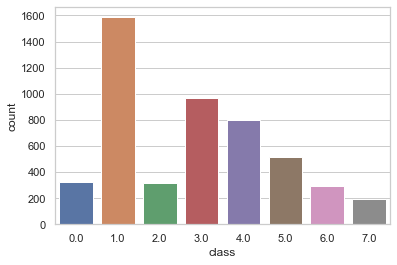

In [9]:
sns.set_theme(style="whitegrid")
sns.countplot(x="class", data=df_train)

In [10]:
class_count = pd.DataFrame()
class_count['count'] = df_train['class'].value_counts().sort_index()
class_count['fraction'] = round(class_count['count'] / sum(class_count['count']), 2)
class_count

,count,fraction
0.0,321,0.06
1.0,1586,0.32
2.0,316,0.06
3.0,969,0.19
4.0,797,0.16
5.0,514,0.10
6.0,293,0.06
7.0,194,0.04


## Датасет

In [11]:
class BuildingTechnicsDataset(Dataset):
    def __init__(self, train_df, test_df, transform, 
                 augmentation, num_folds=10):
        """
        Аргументы:
            train_df, test_df (pd.DataFrame): тренировочный и тестовый наборы данных
        """
        self.transform = transform
        self.augmentation = augmentation
        
        #разбиваем индексы на фолды с примерно одинаковым распределением данных
        labels = train_df['class'].unique()
        self.folds_idxs = [np.array([]) for _ in range(num_folds)]
        self.num_folds = num_folds
        
        for label in labels:
            label_idxs = train_df[train_df["class"] == label].index.to_list()
            random.shuffle(label_idxs)
            label_idxs = np.array_split(label_idxs, num_folds)
            label_idxs = df_train[df_train["class"] == label].index.to_list()
            random.shuffle(label_idxs)
            label_idxs = np.array_split(label_idxs, num_folds)
            for i in range(num_folds):
                self.folds_idxs[i] = np.append(self.folds_idxs[i], label_idxs[i])
            self.folds_idxs = sorted(self.folds_idxs, key=len)
        self.folds_idxs = np.sort(self.folds_idxs)
        
        self.full_train_df = train_df
        
        self.test_df = test_df
        self.test_size = len(self.test_df)
        
        self.set_fold(0)

        self.set_split('train') 
    
    @classmethod
    def load_dataset(cls, path_train, path_test, dir_train, dir_test, 
                     transform, augmentation, num_folds=10):
        """Загрузка данных датасета
        Аргументы:
            path_train, path_test (str): пути к тренировочному и тестовому наборам данных
            dir_train, dir_test (str): директории с изображениями
        Возвращает:
            экземпляр BuildingTechnicsDataset
        """
        #загрузка данных
        train_df = pd.read_csv(path_train)
        test_df = pd.read_csv(path_test)
        
        #векторизация изображений
        imgs = []
        for img_id in train_df['ID_img']:
            img = Image.open(dir_train + img_id)
            imgs.append(np.asarray(img))
        train_df.insert(len(train_df.columns), 'image', imgs)
        
        imgs = []
        for img_id in test_df['ID_img']:
            img = Image.open(dir_test + img_id)
            imgs.append(np.asarray(img))
        test_df.insert(len(test_df.columns), 'image', imgs)
        
        return cls(train_df[['image', 'class']], test_df[['image']], 
                   transform, augmentation, num_folds)
    
    def set_fold(self, fold=0):
        if self.num_folds == 1:
            self.train_df = self.full_train_df
            self.train_size = len(self.train_df)
            
            self.val_df = None
            self.val_size = 0
            
        else:   
            self.val_df = self.full_train_df.iloc[self.folds_idxs[fold]]
            self.val_size = len(self.val_df)

            self.train_df = self.full_train_df.drop(self.val_df.index)
            self.train_size = len(self.train_df)

            self.train_df.reset_index(drop=True, inplace=True)
            self.val_df.reset_index(drop=True, inplace=True)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}
        
    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
        Аргументы:
            split (str): "train"/"val"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        image = row['image'].copy()
        
        if self._target_split == 'test':
            pixel_values = self.transform(image)
            return {"pixel_values": torch.squeeze(pixel_values)}
        else:
            label = int(row['class'])
            if self._target_split == 'train':
                image = self.augmentation(image, label)
            pixel_values = self.transform(image)
            return {"pixel_values": torch.squeeze(pixel_values),
                    "class": label}

    def __len__(self):
        return self._target_size

## Вспомогательные функции

In [12]:
def dataset_images_example(ds):
    sns.set_theme(style="ticks")
    classes = {0: 'автокран',
               1: 'легковой автомобиль',
               2: 'экскаватор',
               3: 'человек',
               4: 'самосвал',
               5: 'карьерный погрузчик',
               6: 'каток',
               7: 'бульдозер'}
    
    print('Количество объектов классов в валидационной выборке:')
    class_count = pd.DataFrame()
    class_count['count'] = ds.val_df['class'].value_counts().sort_index()
    class_count['fraction'] = round(class_count['count'] / sum(class_count['count']), 2)
    print(class_count)
    
    
    fig, axes = plt.subplots(2, 5, figsize=(13, 6))

    for idx, data in enumerate((ds.train_df, ds.val_df)):
        for jdx, kdx in enumerate(np.random.randint(0, len(data), size=5)):
            image, label = data['image'][kdx], data['class'][kdx]
            if idx == 0:
                image = ds.augmentation(image, label)
            axes[idx, jdx].imshow(Image.fromarray(image))
            axes[idx, jdx].set_title(f'Метка: {label}\n{classes[label]}')

    axes[0, 0].set_ylabel('Обучающая выборка')
    axes[1, 0].set_ylabel('Валидационная выборка')

    fig.tight_layout()
    plt.show()

In [13]:
def compute_accuracy(conf_matrix, n_classes):
    acc = np.zeros(n_classes)
    for i in range(n_classes):
        tp_fn = np.sum(conf_matrix[i])
        if tp_fn == 0:
            acc[i] = 0.0
        else:
            acc[i] = conf_matrix[i, i] / tp_fn
    return acc

In [14]:
def train_plots(train_loss, val_loss, train_acc, val_acc):
    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)
    
    fig, ax = plt.subplots(10, 1, figsize=(6, 40))

    ax[0].plot(np.arange(len(train_loss)), train_loss, label='train')
    ax[0].plot(np.arange(len(val_loss)), val_loss, label='val')
    ax[0].set_ylim(bottom=0.0, top=0.1)
    ax[0].set_xlabel('Количество эпох обучения')
    ax[0].set_ylabel('loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(np.arange(len(mean_train_acc)), np.mean(train_acc, axis=1), label='train')
    ax[1].plot(np.arange(len(mean_val_acc)), np.mean(val_acc, axis=1), label='val')
    ax[1].set_ylim(bottom=0.9, top=1.01)
    ax[1].set_xlabel('Количество эпох обучения')
    ax[1].set_ylabel('recall')
    ax[1].set_title('Recall (macro)')
    ax[1].legend()
    ax[1].grid(True)

    for i in range(n_classes):
        ax[i + 2].plot(np.arange(len(train_acc[:, i])), train_acc[:, i], label='train')
        ax[i + 2].plot(np.arange(len(val_acc[:, i])), val_acc[:, i], label='val')
        ax[i + 2].set_ylim(bottom=0.9, top=1.01)
        ax[i + 2].set_xlabel('Количество эпох обучения')
        ax[i + 2].set_ylabel('recall')
        ax[i + 2].set_title(classes[i])
        ax[i + 2].legend()
        ax[i + 2].grid(True)

    fig.tight_layout()
    plt.show()

## Обучение модели

In [15]:
def train(model, dataset, loss_func, optimizer, sheduler, epoch, batch_size, validation=True):
        
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    pbar = tqdm.tqdm(range(epoch), total=epoch)

    for _ in pbar:
        ds.set_split('train')
        dl = DataLoader(dataset=dataset, batch_size=batch_size,
                        shuffle=True, drop_last=True)

        running_loss = 0.0
        running_confusion_matrix = np.zeros((n_classes, n_classes))
        model.train()

        for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):
            optimizer.zero_grad()

            outputs = model(batch['pixel_values'].to(device))
            if type(outputs) == tuple:
                outputs, attention = outputs
            loss = loss_func(outputs, batch['class'].to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            preds = np.argmax(outputs.cpu().detach().numpy(), axis=1)
            running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                         labels=np.arange(n_classes))
            loss.backward()
            optimizer.step()

            outputs.cpu()
            del outputs
        sheduler.step()

        train_loss.append(running_loss)
        train_acc.append(compute_accuracy(running_confusion_matrix, n_classes))
        
        if validation:
            ds.set_split('val')
            dl = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=False, drop_last=False)

            running_loss = 0.0
            running_confusion_matrix = np.zeros((n_classes, n_classes))
            model.eval()

            with torch.no_grad():

                for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):

                    outputs = model(batch['pixel_values'].to(device))
                    if type(outputs) == tuple:
                        outputs, = outputs                
                    loss = loss_func(outputs, batch['class'].to(device))

                    loss_batch = loss.item()
                    running_loss += (loss_batch - running_loss) / (idx + 1)

                    preds = np.argmax(outputs.cpu().detach().numpy(), axis=1)
                    running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                                 labels=np.arange(n_classes))
                    outputs.cpu()
                    del outputs

                val_loss.append(running_loss)
                val_acc.append(compute_accuracy(running_confusion_matrix, n_classes))
        
        if validation:
            print('Loss (Train/Test): {0:.3f}/{1:.3f}.\n\
            Classes recall (Train/Test): {2}/{3}.\n\
            Recall (Train/Test): {4:.3f}/{5:.3f}'.format(
                train_loss[-1], val_loss[-1], 
                np.round(train_acc[-1], 2), np.round(val_acc[-1], 2),
                np.mean(train_acc[-1]), np.mean(val_acc[-1])
            ))
            pbar.set_description(
                        'Loss (Train/Test): {0:.3f}/{1:.3f}.\nRecall (Train/Test): {2:.3f}/{3:.3f}\n'.format(
                            train_loss[-1], val_loss[-1], np.mean(train_acc[-1]), np.mean(val_acc[-1])
                        )
                    )
        else:
            pbar.set_description(
                        'Loss: {0:.3f}.\nRecall: {1:.3f}\n'.format(
                            train_loss[-1], np.mean(train_acc[-1])
                        )
                    )
    return train_loss, val_loss, train_acc, val_acc

In [16]:
def cross_validation(model_path, loss_func, optimizer, sheduler, ds, num_folds=5, 
                     n_classes=8, epoch=10, batch_size=16, seed=42):
    
    results = {'train_loss': np.empty((0, epoch), float),
               'val_loss': np.empty((0, epoch), float),
               'train_acc': np.empty((0, epoch, n_classes), float),
               'val_acc': np.empty((0, epoch, n_classes), float)}
    
    for fold in range(num_folds):
        set_seed(seed)
        ds.set_fold(fold)

        current_model = ViTForImageClassification.from_pretrained(model_path, num_labels=n_classes, return_dict=False)
        current_model.to(device)
        current_loss_func = loss_func
        current_optimizer = optimizer(current_model)
        current_sheduler = sheduler(current_optimizer)

        train_loss, val_loss, train_acc, val_acc = train(current_model, ds, current_loss_func,
                                                         current_optimizer, current_sheduler, 
                                                         epoch, batch_size)
        
        results['train_loss'] = np.append(results['train_loss'], [train_loss], axis=0)
        results['val_loss'] = np.append(results['val_loss'], [val_loss], axis=0)
        results['train_acc'] = np.append(results['train_acc'], [train_acc], axis=0)
        results['val_acc'] = np.append(results['val_acc'], [val_acc], axis=0)

        current_model.cpu()
        del current_model
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return results

Количество объектов классов в валидационной выборке:
     count  fraction
0.0    161      0.06
1.0    793      0.32
2.0    158      0.06
3.0    484      0.19
4.0    399      0.16
5.0    257      0.10
6.0    146      0.06
7.0     97      0.04


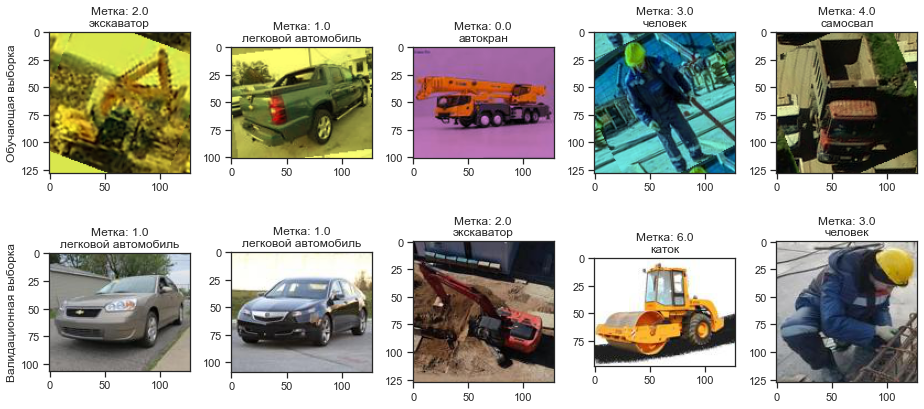

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.559/0.238.
            Classes recall (Train/Test): [0.7  0.95 0.63 0.93 0.84 0.79 0.69 0.63]/[0.95 0.95 0.92 1.   0.83 0.91 0.91 0.91].
            Recall (Train/Test): 0.771/0.923


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.250/0.107.
            Classes recall (Train/Test): [0.91 0.97 0.86 0.98 0.91 0.92 0.85 0.86]/[0.95 0.97 0.95 1.   0.95 0.96 0.95 0.92].
            Recall (Train/Test): 0.906/0.957


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.152/0.084.
            Classes recall (Train/Test): [0.91 0.98 0.88 0.98 0.94 0.97 0.93 0.91]/[0.97 0.99 0.96 0.99 0.92 0.97 0.95 0.99].
            Recall (Train/Test): 0.937/0.969


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.062/0.055.
            Classes recall (Train/Test): [0.99 0.99 0.94 0.99 0.98 0.98 0.95 0.98]/[0.99 0.99 0.96 1.   0.97 0.97 0.99 0.99].
            Recall (Train/Test): 0.974/0.983


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.045/0.047.
            Classes recall (Train/Test): [0.98 0.99 0.98 0.99 0.98 0.98 0.97 0.98]/[0.99 1.   0.97 1.   0.96 0.97 0.97 0.99].
            Recall (Train/Test): 0.983/0.982


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.023/0.042.
            Classes recall (Train/Test): [0.99 1.   0.97 1.   0.99 0.99 0.99 0.99]/[0.98 1.   0.97 1.   0.98 0.97 0.99 0.99].
            Recall (Train/Test): 0.992/0.983


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.018/0.037.
            Classes recall (Train/Test): [1.   1.   0.98 1.   0.99 1.   0.99 0.99]/[0.99 1.   0.96 1.   0.98 0.98 0.99 0.99].
            Recall (Train/Test): 0.993/0.985


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.011/0.039.
            Classes recall (Train/Test): [0.99 1.   0.99 1.   0.99 1.   1.   1.  ]/[0.99 1.   0.96 1.   0.98 0.98 0.99 0.99].
            Recall (Train/Test): 0.998/0.985


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.008/0.039.
            Classes recall (Train/Test): [0.99 1.   0.99 1.   1.   1.   1.   1.  ]/[0.99 1.   0.97 1.   0.97 0.98 0.99 0.99].
            Recall (Train/Test): 0.998/0.986


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.008/0.038.
            Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   1.  ]/[0.99 1.   0.97 1.   0.97 0.98 0.99 0.99].
            Recall (Train/Test): 0.999/0.986


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.538/0.129.
            Classes recall (Train/Test): [0.72 0.96 0.68 0.91 0.83 0.79 0.75 0.65]/[0.96 0.98 0.96 1.   0.94 0.88 0.99 0.99].
            Recall (Train/Test): 0.787/0.960


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.175/0.106.
            Classes recall (Train/Test): [0.94 0.98 0.92 0.98 0.94 0.89 0.92 0.93]/[0.97 0.98 0.84 1.   0.97 0.99 0.94 0.98].
            Recall (Train/Test): 0.936/0.958


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.085/0.105.
            Classes recall (Train/Test): [0.97 0.99 0.95 0.99 0.97 0.96 0.96 0.96]/[0.92 0.97 0.87 1.   0.98 0.98 0.96 0.94].
            Recall (Train/Test): 0.967/0.953


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.082/0.045.
            Classes recall (Train/Test): [0.94 0.99 0.95 0.99 0.96 0.97 0.97 0.98]/[0.99 1.   0.97 1.   0.99 0.96 0.98 1.  ].
            Recall (Train/Test): 0.970/0.986


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.038/0.060.
            Classes recall (Train/Test): [0.99 0.99 0.97 1.   0.98 0.98 0.99 0.98]/[0.98 0.99 0.9  1.   0.99 0.96 0.99 1.  ].
            Recall (Train/Test): 0.984/0.976


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.024/0.039.
            Classes recall (Train/Test): [0.99 1.   0.97 1.   0.99 0.99 1.   1.  ]/[0.98 1.   0.97 1.   0.99 0.98 0.98 0.97].
            Recall (Train/Test): 0.992/0.983


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.010/0.039.
            Classes recall (Train/Test): [0.99 1.   0.99 1.   1.   1.   1.   1.  ]/[0.99 1.   0.97 1.   0.99 0.98 0.97 0.97].
            Recall (Train/Test): 0.997/0.982


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.007/0.039.
            Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.99 1.   0.97 1.   0.99 0.98 0.97 0.97].
            Recall (Train/Test): 0.999/0.983


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.012/0.038.
            Classes recall (Train/Test): [0.99 1.   1.   1.   0.99 1.   1.   0.98]/[0.99 1.   0.97 1.   0.99 0.98 0.97 0.98].
            Recall (Train/Test): 0.995/0.984


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loss (Train/Test): 0.005/0.038.
            Classes recall (Train/Test): [0.99 1.   1.   1.   1.   1.   1.   1.  ]/[0.99 1.   0.97 1.   0.99 0.98 0.97 0.98].
            Recall (Train/Test): 0.999/0.984


In [87]:
n_classes = 8
epoch = 10
batch_size = 16
num_folds = 2
seed = 42
model_path = 'google/vit-base-patch16-224-in21k'

def augmentation(img, label):
    img = img.copy()
    if random.random() > 0.5:
        img = np.fliplr(img)
    p = random.random()
    if p < 0.33:
        img[:, :, 0] = np.round(random.random() * img[:, :, 0])
    elif p < 0.66:
        img[:, :, 1] = np.round(random.random() * img[:, :, 1])
    else:
        img[:, :, 2] = np.round(random.random() * img[:, :, 2])
    p = random.random()
    if random.random() > 0.5:
        img = rotate(img, angle=30 * p, reshape=False, mode = 'wrap')
    else:
        img = rotate(img, angle=-30 * p, reshape=False, mode = 'wrap')

    return img

for _ in [16]:
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
    transform = lambda img: feature_extractor(img, return_tensors='pt')['pixel_values']
    
    set_seed(seed)
    ds = BuildingTechnicsDataset.load_dataset(PATH_TRAIN, PATH_TEST, DIR_TRAIN, DIR_TEST, transform, 
                                              augmentation, num_folds)
    dataset_images_example(ds)

    loss_func = nn.CrossEntropyLoss()
    optimizer = lambda model: optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    sheduler = lambda optimizer: optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    cross_valid_result = cross_validation(model_path, loss_func, optimizer, sheduler, ds,
                                          num_folds, n_classes, epoch, batch_size, seed)
    np.save('cross_val_{}.npy'.format(_), cross_valid_result)

    gc.collect()
    torch.cuda.empty_cache()

In [17]:
n_classes = 8
epoch = 10
batch_size = 16
num_folds = 1
seed = 42
model_path = 'google/vit-base-patch16-224-in21k'

def augmentation(img, label):
    img = img.copy()
    if random.random() > 0.5:
        img = np.fliplr(img)
    p = random.random()
    if p < 0.33:
        img[:, :, 0] = np.round(random.random() * img[:, :, 0])
    elif p < 0.66:
        img[:, :, 1] = np.round(random.random() * img[:, :, 1])
    else:
        img[:, :, 2] = np.round(random.random() * img[:, :, 2])
    p = random.random()
    if random.random() > 0.5:
        img = rotate(img, angle=30 * p, reshape=False, mode = 'wrap')
    else:
        img = rotate(img, angle=-30 * p, reshape=False, mode = 'wrap')

    return img

for _ in [12]:
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
    transform = lambda img: feature_extractor(img, return_tensors='pt')['pixel_values']
    
    set_seed(seed)
    ds = BuildingTechnicsDataset.load_dataset(PATH_TRAIN, PATH_TEST, DIR_TRAIN, DIR_TEST, transform, 
                                              augmentation, num_folds)

    model = ViTForImageClassification.from_pretrained(model_path, num_labels=n_classes, 
                                                      return_dict=False, output_attentions=True)
    model.to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    sheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    train(model, ds, loss_func, optimizer, sheduler, epoch, batch_size, validation=False)

    gc.collect()
    torch.cuda.empty_cache()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

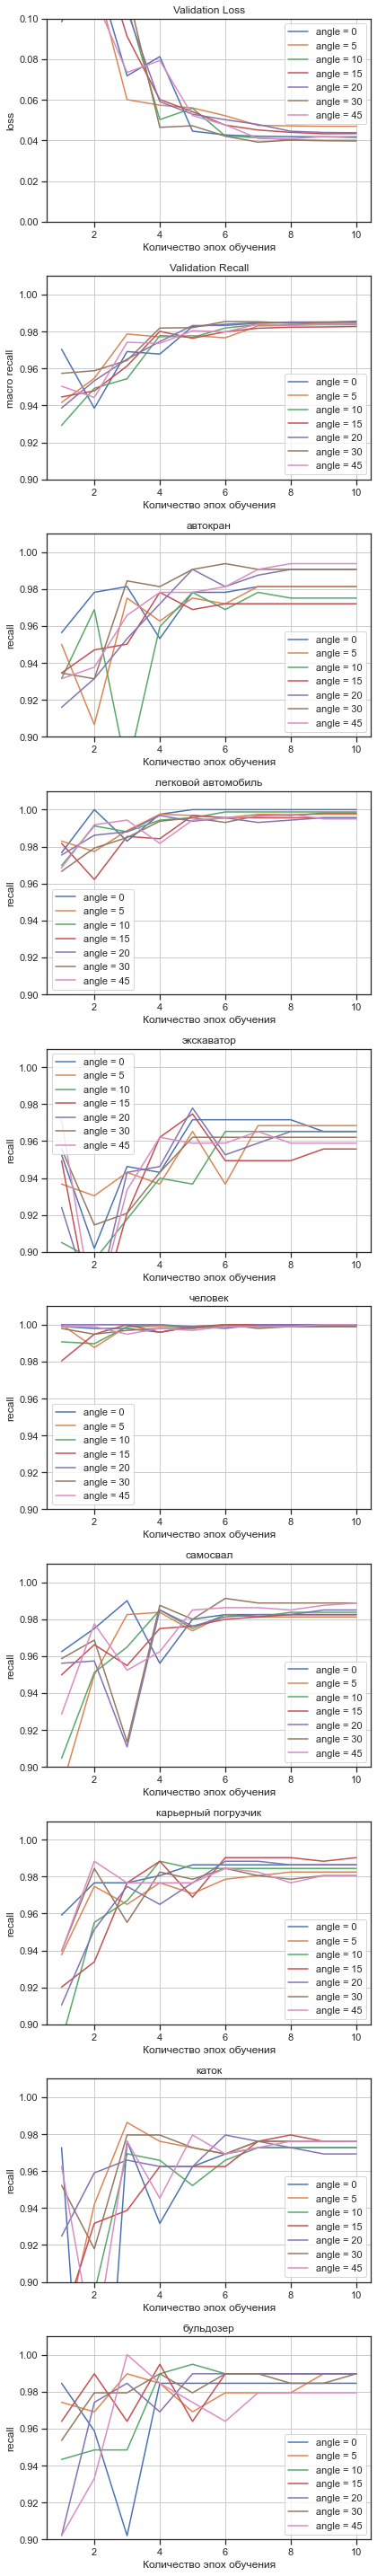

In [51]:
classes = {0: 'автокран',
           1: 'легковой автомобиль',
           2: 'экскаватор',
           3: 'человек',
           4: 'самосвал',
           5: 'карьерный погрузчик',
           6: 'каток',
           7: 'бульдозер'}

fig, ax = plt.subplots(10, 1, figsize=(6, 40), )
for angle in [0, 5, 10, 15, 20, 30, 45]:
    res = np.load('cross_val_angle_{}.npy'.format(angle), allow_pickle='TRUE').item()
    mean_val_loss = np.mean(res['val_loss'], axis=0)
    mean_val_acc = np.mean(res['val_acc'], axis=0)
    macro_val_acc = np.mean(mean_val_acc, axis=1)
    
    ax[0].plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, 
               label='angle = {}'.format(angle))
    
    ax[1].plot(np.arange(len(macro_val_acc)) + 1, macro_val_acc, 
               label='angle = {}'.format(angle))
    
    for i in range(len(classes)):
        ax[i + 2].plot(np.arange(len(mean_val_acc[:, i])) + 1, mean_val_acc[:, i], 
                       label='angle = {}'.format(angle))
        
ax[0].set_xlabel('Количество эпох обучения')
ax[0].set_ylabel('loss')
ax[0].set_ylim(bottom=0.0, top=0.1)
ax[0].set_title('Validation Loss')
ax[0].legend()
ax[0].grid(True)
    
ax[1].set_xlabel('Количество эпох обучения')
ax[1].set_ylabel('macro recall')
ax[1].set_title('Validation Recall')
ax[1].set_ylim(bottom=0.9, top=1.01)
ax[1].legend()
ax[1].grid(True)

for i in range(len(classes)):
    ax[i + 2].set_xlabel('Количество эпох обучения')
    ax[i + 2].set_ylabel('recall')
    ax[i + 2].set_ylim(bottom=0.9, top=1.01)
    ax[i + 2].set_title(classes[i])
    ax[i + 2].legend()
    ax[i + 2].grid(True)

fig.tight_layout()
plt.show()

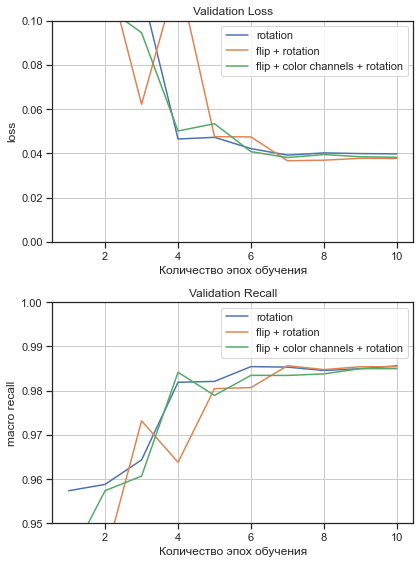

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), )
labels = {'angle_30': 'rotation', '15': 'flip + rotation', '16': 'flip + color channels + rotation'}
for angle in ['angle_30', '15', '16']:
    res = np.load('cross_val_{}.npy'.format(angle), allow_pickle='TRUE').item()
    mean_val_loss = np.mean(res['val_loss'], axis=0)
    mean_val_acc = np.mean(res['val_acc'], axis=0)
    macro_val_acc = np.mean(mean_val_acc, axis=1)
    
    ax[0].plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, 
               label=labels[angle])
    
    ax[1].plot(np.arange(len(macro_val_acc)) + 1, macro_val_acc, 
               label=labels[angle])
        
ax[0].set_xlabel('Количество эпох обучения')
ax[0].set_ylabel('loss')
ax[0].set_ylim(bottom=0.0, top=0.1)
ax[0].set_title('Validation Loss')
ax[0].legend()
ax[0].grid(True)
    
ax[1].set_xlabel('Количество эпох обучения')
ax[1].set_ylabel('macro recall')
ax[1].set_title('Validation Recall')
ax[1].set_ylim(bottom=0.95, top=1.)
ax[1].legend()
ax[1].grid(True)

fig.tight_layout()
plt.show()

In [ ]:
LR = [(11e-3, 1e-3), (11e-3, 1e-4), (11e-3, 1e-5), (11e-3, 1e-6)]
n = 12

for idx_lr, lr in enumerate(LR):
    base_lr, min_lr = lr
    
    set_seed(42)
    n_classes = 8
    epoch = 10
    batch_size = 16

    model.cpu()
    del model

    gc.collect()
    torch.cuda.empty_cache()

    model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=n_classes)#, output_attentions=True
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
    sheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=min_lr)


    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    pbar = tqdm.tqdm(range(epoch), total=epoch)

    for _ in pbar:
        ds.set_split('train')
        dl = DataLoader(dataset=ds, batch_size=batch_size,
                        shuffle=True, drop_last=True)

        running_loss = 0.0
        running_confusion_matrix = np.zeros((n_classes, n_classes))
        model.train()

        for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):
            optimizer.zero_grad()

            outputs = model(batch['pixel_values'].to(device))
            loss = loss_func(outputs['logits'], batch['class'].to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
            running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                         labels=np.arange(n_classes))
            loss.backward()
            optimizer.step()

            outputs['logits'].cpu()
            del outputs
        sheduler.step()

        train_loss.append(running_loss)
        train_acc.append(compute_accuracy(running_confusion_matrix, n_classes))

        ds.set_split('val')
        dl = DataLoader(dataset=ds, batch_size=batch_size,
                        shuffle=False, drop_last=False)

        running_loss = 0.0
        running_confusion_matrix = np.zeros((n_classes, n_classes))
        model.eval()

        with torch.no_grad():

            for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):

                outputs = model(batch['pixel_values'].to(device))
                loss = loss_func(outputs['logits'], batch['class'].to(device))

                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)

                preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
                running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                             labels=np.arange(n_classes))
                outputs['logits'].cpu()
                del outputs

            val_loss.append(running_loss)
            val_acc.append(compute_accuracy(running_confusion_matrix, n_classes))

        print('Loss (Train/Test): {0:.3f}/{1:.3f}.\n\
        Classes recall (Train/Test): {2}/{3}.\n\
        Recall (Train/Test): {4:.3f}/{5:.3f}'.format(
            train_loss[-1], val_loss[-1], 
            np.round(train_acc[-1], 2), np.round(val_acc[-1], 2),
            np.mean(train_acc[-1]), np.mean(val_acc[-1])
        ))
        pbar.set_description(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}.\nRecall (Train/Test): {2:.3f}/{3:.3f}\n'.format(
                        train_loss[-1], val_loss[-1], np.mean(train_acc[-1]), np.mean(val_acc[-1])
                    )
                )
    np.save('train_loss_lr_{}.npy'.format(idx_lr + n), train_loss)
    np.save('train_acc_lr_{}.npy'.format(idx_lr + n), train_acc)
    np.save('val_loss_lr_{}.npy'.format(idx_lr + n), val_loss)
    np.save('val_acc_lr_{}.npy'.format(idx_lr + n), val_acc)

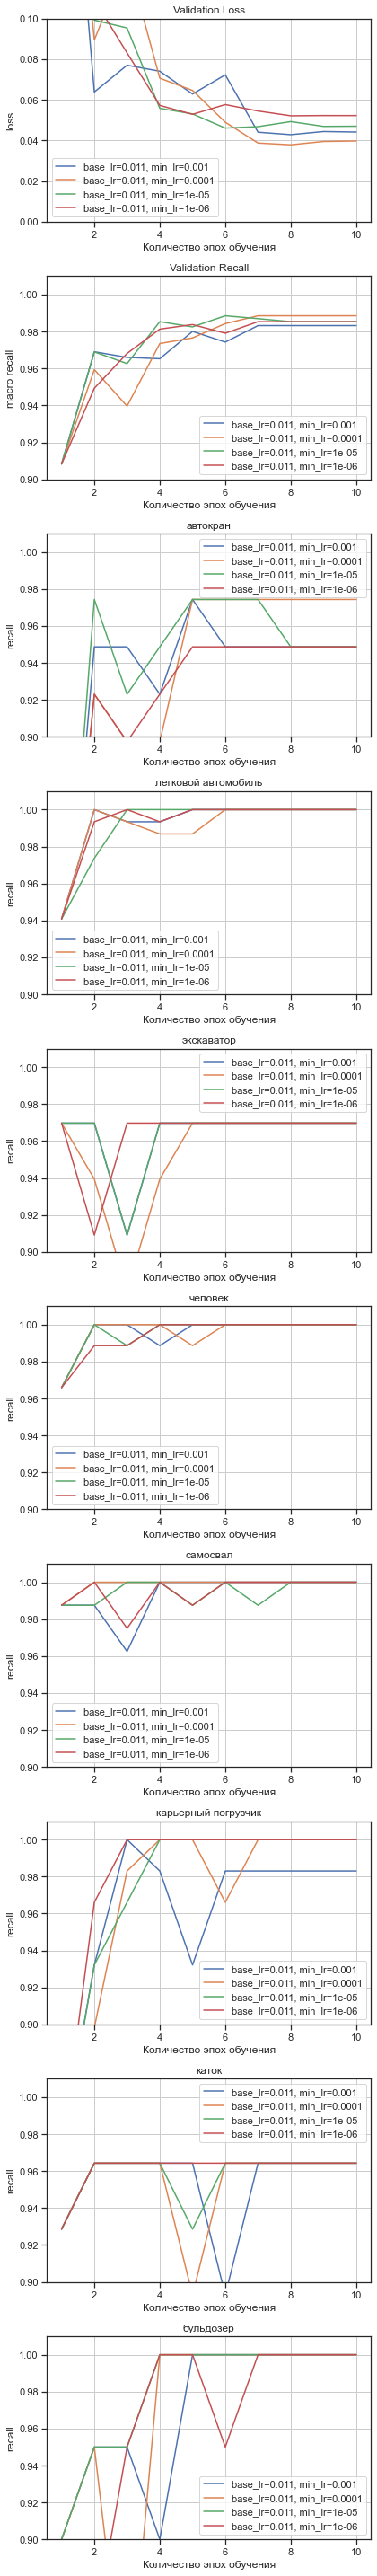

In [56]:
n = 12
fig, ax = plt.subplots(10, 1, figsize=(6, 40), )
for i in range(4):
    base_lr, min_lr = LR[i]
    ax[0].plot(np.arange(1, 11), np.load('val_loss_lr_{}.npy'.format(i + n)), 
               label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
ax[0].set_xlabel('Количество эпох обучения')
ax[0].set_ylabel('loss')
ax[0].set_ylim(bottom=0.0, top=0.1)
ax[0].set_title('Validation Loss')
ax[0].legend()
ax[0].grid(True)

for i in range(4):
    base_lr, min_lr = LR[i]
    val_acc = np.load('val_acc_lr_{}.npy'.format(i + n))
    ax[1].plot(np.arange(1, 11), np.mean(val_acc, axis=1), 
               label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
    for j in range(n_classes):
        ax[j + 2].plot(np.arange(1, 11), val_acc[:, j], 
                       label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
    
ax[1].set_xlabel('Количество эпох обучения')
ax[1].set_ylabel('macro recall')
ax[1].set_title('Validation Recall')
ax[1].set_ylim(bottom=0.9, top=1.01)
ax[1].legend()
ax[1].grid(True)

for i in range(n_classes):
    ax[i + 2].set_xlabel('Количество эпох обучения')
    ax[i + 2].set_ylabel('recall')
    ax[i + 2].set_ylim(bottom=0.9, top=1.01)
    ax[i + 2].set_title(classes[i])
    ax[i + 2].legend()
    ax[i + 2].grid(True)

fig.tight_layout()
plt.show()

## Предсказание для теста

In [18]:
preds = np.array([])

model.eval()

ds.set_split('test')
dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False, drop_last=False)
    
with torch.no_grad():

    for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl)):

        outputs = model(batch['pixel_values'].to(device))
        if type(outputs) == tuple:
            outputs, attentions = outputs 
            
        preds_batch = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        preds = np.concatenate((preds, preds_batch), axis=None)
        
        outputs.cpu()
        del outputs

  0%|          | 0/134 [00:00<?, ?it/s]

In [19]:
preds.shape

(2138,)

In [20]:
df_test = df_test.drop(["class"], axis = 1)
df_test["class"] = preds
df_test.head()

,ID_img,class
0,0.jpg,5.0
1,1.jpg,5.0
2,2.jpg,1.0
3,3.jpg,1.0
4,4.jpg,6.0


In [59]:
df_test.to_csv("submit8.csv", index=False)

## Визуализация внимания

In [21]:
import cv2

def get_attention_map(img, get_mask=True):
    x = feature_extractor(img, return_tensors='pt')['pixel_values']
    #x.size()

    outputs = model(x.to(device))
    logits, att_mat = outputs
    logits = logits.cpu()

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n].cpu(), joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original', fontsize=28)
    ax2.set_title('Attention Map Last Layer', fontsize=28)
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

In [49]:
i = 1772
img = Image.fromarray(ds.test_df['image'][i])

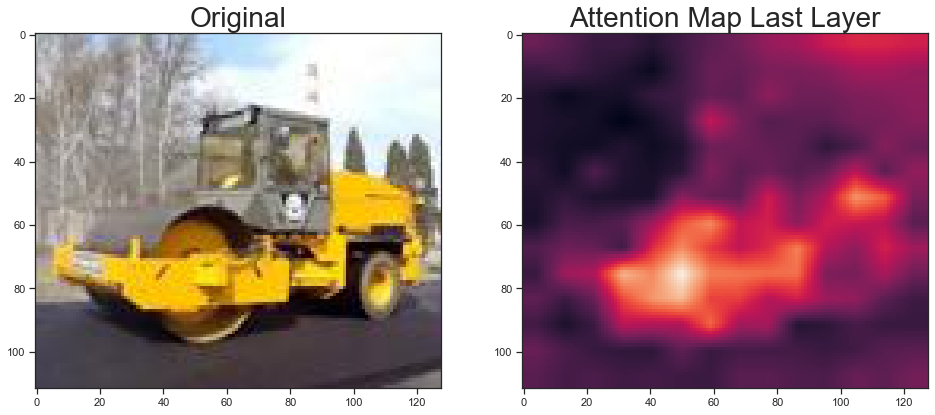

In [50]:
sns.set_theme(style="ticks")
result1 = get_attention_map(img)
plot_attention_map(img, result1)